# E6 — Building ion current models from data (part 2)

This notebook contains interactive exercises related to the L5 and L6 sessions of the SSCP2018. 



In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import scipy.optimize as opt
import math
from E6 import *
import pandas as pd
from scipy.integrate import odeint

In [2]:
#load the data from the activation tutorial
SSA_data = pd.read_csv('Act_table.csv')
peaks = np.array((SSA_data.Peak_INa))
tau = np.array(SSA_data.Tau_inact)
V_steps = np.array(SSA_data.Voltage)
# print(SSA_data)
# print(peaks)
# print(tau)
# print(V_steps)

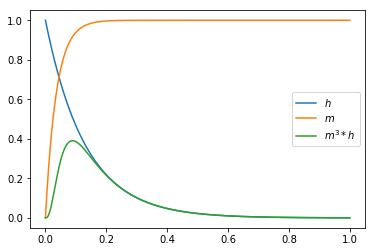

In [3]:
HH_P = np.zeros((15))
HH_P[0] = 15.0816
HH_P[1] = 0.32
HH_P[2] = -0.0089778037307
HH_P[3] = -0.1
HH_P[4] = 0.08
HH_P[5] = -0.0909090909091
HH_P[6] = 1.04951082543e-06
HH_P[7] = -0.147058823529
HH_P[8] = 0.13
HH_P[9] = 0.0497581410839
HH_P[10] = -0.0900900900901
HH_P[11] = 310000.0
HH_P[12] = 3.56
HH_P[13] = 0.079
HH_P[14] = 100

t = np.linspace(0,1,1001)
y0 = [0,1]
V_hold = 40 
y = odeint(HH, y0, t, (V_hold,HH_P))
m = y[:,0]
h = y[:,1]
plt.plot(t,h,t,m,t,pow(m,3)*h); plt.legend((r'$h$',r'$m$',r'$m^3*h$')); plt.show()

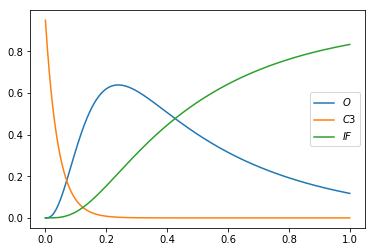

In [4]:
#Na Channel parameter set 
P1 = np.zeros((31))
P1[0] = 3.802; P1[1] = 0.1027;P1[2] = 2.5;P1[3] = 17;P1[4] = 15;P1[5] = 12;P1[6] = 0.2;P1[7] = 0.23;P1[8] = 0.25;
P1[9] = 0.1917; P1[10] = 20.3;
P1[11] = 0.2; P1[12] = 2.5;
P1[13] = 0.22; P1[14] = 7.5;
P1[15] = 0.188495; P1[16] = 16.6; P1[17] = 0.393956;
P1[18] = 7e-07; P1[19] = 7.2; 
P1[20] = 0.0084/1.9; P1[21] = 2e-05; 
P1[22] = 100; 
P1[23] = 8.9554e-07; P1[24] = 11.3944; 
P1[25] = 4.8696e-05; P1[26] = 23.2696; 
P1[28] = 2.868e-04; P1[29] = 35.9898;
P1[30] = 70

V_init = -90   
y0 = Markov_Na_Init(P1,V_init)
    
t = np.linspace(0,1,1001) 
V_hold = 40 
y = odeint(Markov_Na, y0, t, (V_hold, P1))

O = y[:,0]
IF = y[:,1]
IM1 = y[:,2]
IM2 = y[:,3]
C3 = y[:,4]
C2 = y[:,5]
C1 = y[:,6]
IC3 = y[:,7]
IC2 = y[:,8]

plt.plot(t,O,t,C3,t,IF); plt.legend((r'$O$',r'$C3$',r'$IF$')); plt.show()

In [5]:
def Activation(P,V,model):
    
    # An I_Na activation voltage clamp protocol
    # Constants
    R = 8314 # mJ/(K mol)
    T = 273.0+37.0 #  K
    F = 96485.33289 # C/mol 
    Na_o = 140.0
    Na_i = 10.0;
    E_Na = (R*T/F)*math.log(Na_o/Na_i) # mV
    
    # Activation voltage-clamp square pulse protocol
    step_duration = 1000
    ntsteps = int(step_duration*100)
    
    #Initialize outputs
    Po_out = np.zeros((ntsteps,len(V)))
    model_I = np.zeros((ntsteps,len(V)))
    model_peaks = np.zeros((len(V)))
    
    #Step through the test potentials in your reference data
    for idx,i in enumerate(V): 
        V_hold = -90
        if model == 1: # Markov model
            # First reset your initial conditions to the holding potential at the beginning of each step
            # Question: Is this always a good idea? Why or why not?
            y0 = Markov_Na_Init(P1,V_hold)
            # Run the model
            t = np.linspace(0,10,100000) 
            y = odeint(Markov_Na, y0, t, (V[idx], P1))
            #store the open probability data and calculate the error metrics
            Po_out[:,idx] = y[:,0]
            model_I[:,idx] = P1[-1]*Po_out[:,idx]*(V[idx]-E_Na)
            model_peaks[idx] = model_I[:,idx].min()
            out = {'t':t, 'Po':Po_out,'I':model_I,'I_peak':model_peaks}
        else:
            y0 = [0,1] # More simple initialization 
            t = np.linspace(0,10,100000) 
            y = odeint(HH, y0, t, (V[idx], HH_P))
            #store the open probability data and calculate the error metrics
            m = y[:,0]
            h = y[:,1] 
            Po_out[:,idx] = pow(m,3)*h   
            model_I[:,idx] = HH_P[-1]*Po_out[:,idx]*(V[idx]-E_Na)
            model_peaks[idx] = model_I[:,idx].min()
            out = {'t':t, 'Po':Po_out,'I':model_I,'I_peak':model_peaks}
      
    return out



In [6]:
V_steps = np.arange(-100,50,10)
HH_dats = Activation(HH_P,V_steps,0)
HH_I_peaks = HH_dats['I_peak']
HH_I = HH_dats['I']
HH_Po = HH_dats['Po']
HH_t = HH_dats['t']

Markov_dats = Activation(P1,V_steps,1)
Markov_I_peaks = Markov_dats['I_peak']
Markov_I = Markov_dats['I']
Markov_Po = Markov_dats['Po']
Markov_t = Markov_dats['t']
#print (t)
#print (Po)
#print (model_I)
    

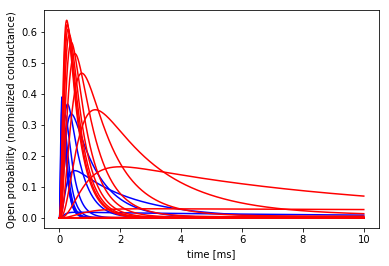

In [7]:
plt.figure()
plt.plot(HH_t,HH_Po,'b')
plt.plot(Markov_t,Markov_Po,'r')
plt.xlabel('time [ms]')
plt.ylabel('Open probability (normalized conductance)')

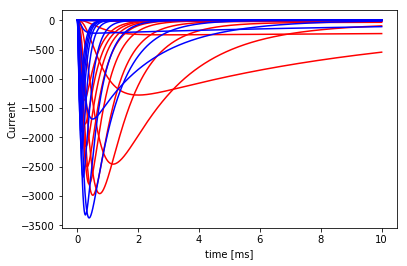

In [8]:
plt.figure()
plt.plot(Markov_t,Markov_I,'r')
plt.plot(HH_t,HH_I,'b')
plt.xlabel('time [ms]')
plt.ylabel('Current')

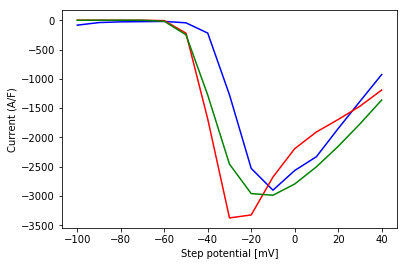

In [9]:
plt.figure()
plt.plot(V_steps,peaks,'b-')
plt.plot(V_steps,HH_I_peaks,'r-')
plt.plot(V_steps,Markov_I_peaks,'g-')
plt.xlabel('Step potential [mV]')
plt.ylabel('Current (A/F)')

In [18]:
def cost(P,V,I):
    
    P = P.tolist()
    outs = Activation(P,V,1)
    model_peaks = outs['I_peak']
       
    dev_vector = model_peaks - I
    error = np.linalg.norm(dev_vector,2)
        
    return error

In [19]:
[P_opt, f_opt, iters, funcalls, warnflag] = opt.fmin(cost, P1, args=(V_steps,peaks),
                                                    maxiter = 10000, maxfun = 10000, full_output=True, disp=True)

Optimization terminated successfully.
         Current function value: 1809.519044
         Iterations: 17
         Function evaluations: 560


In [20]:
Opt_out = Activation(P_opt,V_steps,1)
Opt_I_peaks = Opt_out['I_peak']
Opt_I = Opt_out['I']
Opt_Po = Opt_out['Po']
Opt_t = Opt_out['t']

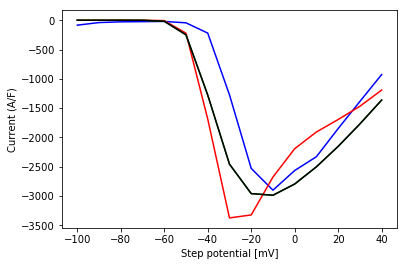

In [21]:
plt.figure()
plt.plot(V_steps,peaks,'b-')
plt.plot(V_steps,HH_I_peaks,'r-')
plt.plot(V_steps,Markov_I_peaks,'g-')
plt.plot(V_steps,Opt_I_peaks,'k-')
plt.xlabel('Step potential [mV]')
plt.ylabel('Current (A/F)')